In [2]:
import numpy as np
import nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import plot
from nn import io, preprocess

**Ashvin Ravi \
March 18, 2024 \
BMI 203**

# Final Project NN 

## Part 1: Digits Autoencoder

### Instructions (copied from GitHub)
**Background** \
An autoencoder is a neural network that takes an input, encodes it into a lower-dimensional latent space through "encoding" layers, and then attempts to reconstruct the original input using "decoding" layers. Autoencoders are often used for dimensionality reduction.

**Your task** \
You will train a 64x16x64 autoencoder on the digits dataset. All of the following work should be done in a Jupyter Notebook.

**To-do** \
Load the digits dataset through sklearn using sklearn.datasets.load_digits().
Split the data into training and validation sets.
Generate an instance of your NeuralNetwork class with a 64x16x64 autoencoder architecture.
Train your autoencoder on the training data.
Plot your training and validation loss by epoch.
Quantify your average reconstruction error over the validation set.
Explain why you chose the hyperparameter values you did.

### Explanation: 
The gap between training and validation loss should be minimized. If the gap is large, it means that the model is overfitting the training data. Using a learning rate of 0.005 and epochs of 400, the loss seems to stay the same/plateaus after at least 200 iterations, meaning that 400 epochs would be more than enough. In addition, a higher learning rate (0.1) increases the gap between training and validation loss and introduces variation, where the loss is very variable/does not settle on a minimum. Therefore, I pick 400 epochs and lr=0.01 for my hyperparameters. 

Finally, using relu() as the activation function for both layers seems to be a much better choice as opposed to sigmoid. 

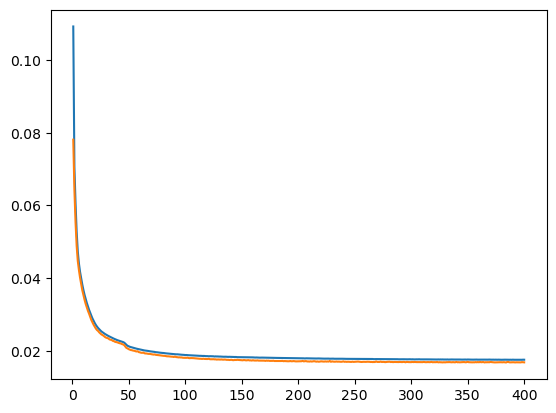

In [76]:
# Load the digits dataset
digits = load_digits()

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)

# Split the data into training and testing sets
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=42)

# Define and train the autoencoder
autoencoder = nn.NeuralNetwork(
    nn_arch=[{'input_dim': 64, 'output_dim': 16, 'activation': '_relu'},
             {'input_dim': 16, 'output_dim': 64, 'activation': '_relu'}],
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=400,
    loss_function='_mean_squared_error'
)

per_epoch_loss_train, per_epoch_loss_validation = autoencoder.fit(X_train, X_train, X_test, X_test)

loss_df = pd.DataFrame(per_epoch_loss_train)
loss_df = loss_df.rename({0: 'loss_train'}, axis='columns')
loss_df['loss_validation'] = per_epoch_loss_validation
loss_df['epochs'] = loss_df.index + 1

plot(loss_df['epochs'], loss_df['loss_train'])
plot(loss_df['epochs'], loss_df['loss_validation'])

### Reconstruction Error

For reconstruction error, I use the mean squared error to calculate the MSE of X_test (true images) vs. the reconstructed images (predict(X_test)). With the hyperparameters I tuned, this yields a reconstruction error/loss of about 0.017. 

In [78]:
reconstructed_images = autoencoder.predict(X_test)

reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=1)
average_reconstruction_error = np.mean(reconstruction_errors)

print("Average Reconstruction Error:", average_reconstruction_error)

Average Reconstruction Error: 0.016879728003062183


## Part 2: Train a Classifier for predicting DNA binding sites

In this part, I train a classifier for predicting DNA binding sites in yeast using positive sequences that distinguish transcription factors, and negative sequences, where it is known that there are no transcription factors within these negative sequences. First, I read in the positive and negative sequences using the io methods. 

In [15]:
positive = io.read_text_file('data/rap1-lieb-positives.txt')
negative = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')
len(negative)
equal_length_negative = []

Next, because the negative sequences are much longer than the positive sequences (1000 vs. 17), I split the negative sequences into substrings of length 17, and filter out sequences that don't have length 17 (since this would be inconsistent with the autoencoder architecture, plus we have a good amount of negative training examples/labels already. I also flatten the numpy array once I get 17 sequences for each instance. 

In [16]:
for sequence in negative:
    n = 17
    equal_length = [sequence[i:i+n] for i in range(0, len(sequence), n)]
    equal_length_negative.append(equal_length)


negative_sequences = sum(equal_length_negative, [])
negative_sequences = pd.DataFrame(negative_sequences)
negative_sequences['negative'] = negative_sequences[0]
negative_sequences = negative_sequences.drop(columns=0)

negative_sequences = negative_sequences[negative_sequences.negative.apply(lambda x: len(str(x)) == 17)]

Because we have a huge class imbalance (~183,000 negative sequences vs. 137 positive sequences, we can balance our classes using the sample_seqs() method within preprocess. 

In [17]:
positive_sequences = pd.DataFrame(positive)
positive_sequences['positive'] = positive_sequences[0]
positive_sequences = positive_sequences.drop(columns=0)
positive_sequences['labels'] = "positive"

negative_sequences['labels'] = "negative"

positive_sequences = positive_sequences.rename(columns={'positive': 'seq', 'labels': 'labels'})
negative_sequences = negative_sequences.rename(columns={'negative': 'seq', 'labels': 'labels'})


In [18]:
# Concatenate and then randomly shuffle the positive and negative sequences 
sequences = pd.concat([positive_sequences, negative_sequences], ignore_index=True)
sequences = sequences.sample(frac = 1) # randomly permuted/reordered

sequences.index = range(0, 183434, 1)

In [19]:
# Randomly sample same proportion of sequences. 
seq = sequences['seq']
labels = sequences['labels']

# Convert labels to boolean
labels[labels == 'negative'] = False
labels[labels == 'positive'] = True
# print(labels.value_counts())

sampled_seqs, sampled_labels = preprocess.sample_seqs(list(seq), list(labels))

Finally, I one-hot encode my sampled sequence matrix for the autoencoder using the one_hot_encode_seqs() function constructed in preprocess.py. 

In [20]:
one_hot_encode_matrix = [preprocess.one_hot_encode_seqs(seq) for seq in sampled_seqs]
one_hot_encode_matrix = np.vstack(one_hot_encode_matrix)

### Autoencoder construction for neural network

Now, we will set up our autoencoder for classifying TF binding sites. Because we have sequences of length 17, and our one-hot encoded matrix adds 4 positions for each possible nucleotide, we have 68 possible features - one for each possible nucleotide. 

#### First, let's normalize the one-hot encoded matrix. 

In [21]:
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(one_hot_encode_matrix)

For this autoencoder, I chose to have 68 neurons in my input layer, 17 neurons in my hidden layer, and 68 on the output layer. This is because the input matrix has 68 features - 17 is length of your sequences, and 68 = 17 * 4 nucleotides (each space represents a possible nucleotide (after one hot encoding). I use my activation function as sigmoid for both layers here, loss function as MSE. When I increase the learning rate (anything above 0.05, the training loss is MUCH smaller, but the gap between the training loss and validation loss increases. Moreover, as I increase number of epochs at a higher learning rate, the validation loss increases. As a result, I keep the learning rate on the lower end (0.01). To compensate, I have a larger number of epochs (6000). This still isn't perfect, as the gap between training and validation loss remains, especially as the number of epochs increase. 

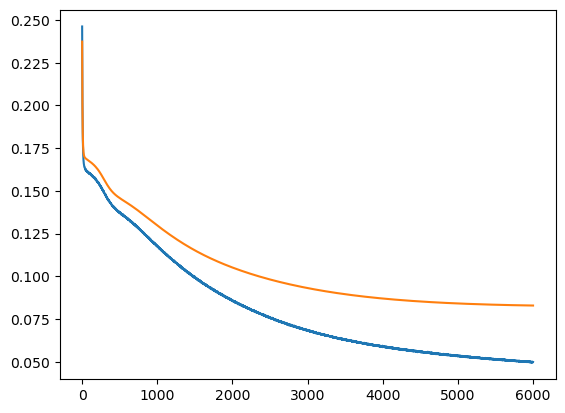

In [71]:
# Split the data into training and testing sets
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=42)

# Define and train the autoencoder
autoencoder = nn.NeuralNetwork(
    nn_arch=[{'input_dim': 68, 'output_dim': 17, 'activation': '_sigmoid'},
             {'input_dim': 17, 'output_dim': 68, 'activation': '_sigmoid'}],
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=6000,
    loss_function='_mean_squared_error'
)

per_epoch_loss_train, per_epoch_loss_validation = autoencoder.fit(X_train, X_train, X_test, X_test)

loss_df = pd.DataFrame(per_epoch_loss_train)
loss_df = loss_df.rename({0: 'loss_train'}, axis='columns')
loss_df['loss_validation'] = per_epoch_loss_validation
loss_df['epochs'] = loss_df.index + 1

plot(loss_df['epochs'], loss_df['loss_train'])
plot(loss_df['epochs'], loss_df['loss_validation'])

I compute validation accuracy as the number of correct predictions (where predicted nucleotids are equal to true nucleotides) divided by the number of sequences. My hyperparameters yield a validation accuracy of 80%. 

In [72]:
prediction = autoencoder.predict(X_test)

prediction_label = np.round(prediction, 0) 

predicted_indices = np.argmax(prediction_label, axis=1)
true_indices = np.argmax(X_test, axis=1)

correct_predictions = np.sum(predicted_indices == true_indices)

# Compute validation accuracy
validation_accuracy = correct_predictions / len(true_indices)
print("Validation Accuracy: ", validation_accuracy)

Validation Accuracy:  0.8
